## Private Semi-structured and Multi-modal RAG w/ LLaMA2 and LLaVA

Many documents contain a mixture of content types, including text, tables, and images. 

Semi-structured data can be challenging for conventional RAG for at least two reasons: 

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search

And the information captured in images is typically lost.

With the emergence of multimodal LLMs, like [GPT4-V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:` 

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis 

`Option 2:` 

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

`Option 3:` 

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image 
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook show how we might tackle this :

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text, (optionally) images along with their summaries for retrieval.
* We will demonstrate `Option 2`, and will follow-up on the other approaches in future cookbooks.

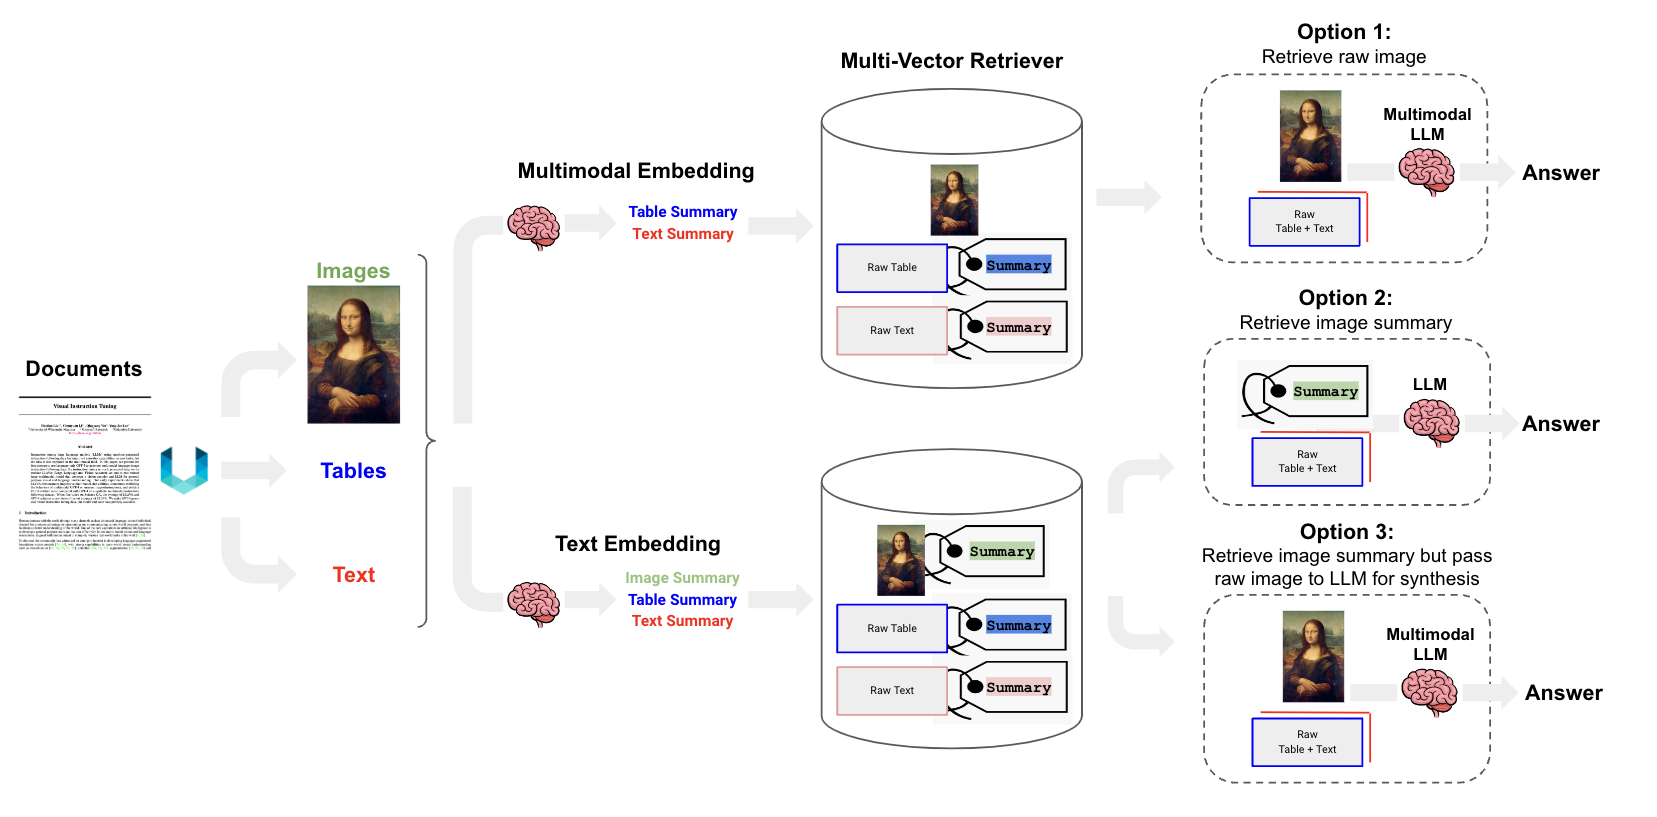

## Packages

In [ ]:
! pip install langchain unstructured[all-docs] pydantic lxml

## Data Loading

### Partition PDF tables, text, and images
  
* `LLaVA` Paper: https://arxiv.org/pdf/2304.08485.pdf
* Use [Unstructured](https://unstructured-io.github.io/unstructured/) to partition elements

In [ ]:
import pandas as pd
from lxml import html
from pydantic import BaseModel
from typing import Any, Optional
from unstructured.partition.pdf import partition_pdf

# Path to save images
path = "/Users/rlm/Desktop/Papers/LLaVA/"

# Get elements
raw_pdf_elements = partition_pdf(filename=path+"LLaVA.pdf",
                                 # Using pdf format to find embedded image blocks
                                 extract_images_in_pdf=True,
                                 # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
                                 # Titles are any sub-section of the document 
                                 infer_table_structure=True, 
                                 # Post processing to aggregate text once we have the title 
                                 chunking_strategy="by_title",
                                 # Chunking params to aggregate text blocks
                                 # Attempt to create a new chunk 3800 chars
                                 # Attempt to keep chunks > 2000 chars 
                                 # Hard max on chunks
                                 max_characters=4000, 
                                 new_after_n_chars=3800, 
                                 combine_text_under_n_chars=2000,
                                 image_output_dir_path=path)

In [2]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
# TableChunk if Table > max chars set above
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 31,
 "<class 'unstructured.documents.elements.Table'>": 3}

In [3]:
class Element(BaseModel):
    type: str
    text: Any

# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

3
31


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

Here, we use ollama.ai to run LLaMA2 locally. 

See details on installation [here](https://python.langchain.com/docs/guides/local_llms).

In [4]:
from langchain.chat_models import ChatOllama
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [5]:
# Prompt 
prompt_text="""You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text) 

# Summary chain 
model = ChatOllama(model="llama2:13b-chat")
summarize_chain = {"element": lambda x:x} | prompt | model | StrOutputParser()

In [6]:
# Apply to text
texts = [i.text for i in text_elements if i.text != ""]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Images

We will implement `Option 2` discussed above: 

* Use a multimodal LLM ([LLaVA](https://llava.hliu.cc/)) to produce text summaries from images
* Embed and retrieve text 
* Pass text chunks to an LLM for answer synthesis 

#### Image summaries 

We will use [LLaVA](https://github.com/haotian-liu/LLaVA/), an open source multimodal model.
 
We will use [llama.cpp](https://github.com/ggerganov/llama.cpp/pull/3436) to run LLaVA locally (e.g., on a Mac laptop):

* Clone [llama.cpp](https://github.com/ggerganov/llama.cpp)
* Download the LLaVA model: `mmproj-model-f16.gguf` and one of `ggml-model-[f16|q5_k|q4_k].gguf` from [LLaVA 7b repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Build
```
mkdir build && cd build && cmake ..
cmake --build .
```
* Run inference across images:
```
/Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
```

In [ ]:
%%bash

# Define the directory containing the images
IMG_DIR=~/Desktop/Papers/LLaVA/

# Loop through each image in the directory
for img in "${IMG_DIR}"*.jpg; do
    # Extract the base name of the image without extension
    base_name=$(basename "$img" .jpg)

    # Define the output file name based on the image name
    output_file="${IMG_DIR}${base_name}.txt"

    # Execute the command and save the output to the defined output file
    /Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

done

In [8]:
import os, glob

# Get all .txt files in the directory
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        img_summaries.append(file.read())

# Clean up residual logging
cleaned_img_summary = [s.split("clip_model_load: total allocated memory: 201.27 MB\n\n", 1)[1].strip() for s in img_summaries]

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

We use GPT4All embeddings to run locally, which are a [CPU optimized version of BERT](https://docs.gpt4all.io/gpt4all_python_embedding.html).

In [9]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import GPT4AllEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=GPT4AllEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore() # <- Can we extend this to images 
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore, 
    docstore=store, 
    id_key=id_key,
)

Found model file at  /Users/rlm/.cache/gpt4all/ggml-all-MiniLM-L6-v2-f16.bin


objc[42078]: Class GGMLMetalClass is implemented in both /Users/rlm/miniforge3/envs/llama2/lib/python3.9/site-packages/gpt4all/llmodel_DO_NOT_MODIFY/build/libreplit-mainline-metal.dylib (0x31f870208) and /Users/rlm/miniforge3/envs/llama2/lib/python3.9/site-packages/gpt4all/llmodel_DO_NOT_MODIFY/build/libllamamodel-mainline-metal.dylib (0x31fc9c208). One of the two will be used. Which one is undefined.


For `option 2` (above): 

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [10]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=s,metadata={id_key: table_ids[i]}) for i, s in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add images
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [Document(page_content=s,metadata={id_key: img_ids[i]}) for i, s in enumerate(cleaned_img_summary)]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, cleaned_img_summary))) # Store the image summary as the raw document

### Sanity Check

Image:

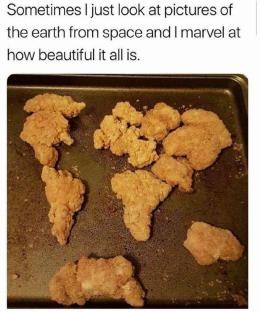

We can retrieve this image summary:

In [17]:
retriever.get_relevant_documents("Images / figures with playful and creative examples")[0]

'The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries. The arrangement of the chicken pieces creates a visually appealing and playful representation of the world, making it an interesting and creative presentation.\n\nmain: image encoded in   865.20 ms by CLIP (    1.50 ms per image patch)'

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

For `option 1` (above): 

* Simply pass retrieved text chunks to LLM, as usual.

For `option 2a` (above): 

* We would pass retrieved image and images to the multi-modal LLM.
* This should be possible soon, once [llama-cpp-python add multi-modal support](https://github.com/abetlen/llama-cpp-python/issues/813).

In [19]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOllama(model="llama2:13b-chat")
# Option 2: Multi-modal LLM
# model = LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()} 
    | prompt 
    | model 
    | StrOutputParser()
)

In [20]:
chain.invoke("What is the performance of LLaVa across across multiple image domains / subjects?")

" Based on the provided context, LLaVA's performance across multiple image domains/subjects is not explicitly mentioned. However, we can infer some information about its performance based on the given text:\n\n1. LLaVA achieves an accuracy of 90.92% on the ScienceQA dataset, which is close to the current SoTA (91.68%).\n2. When prompted with a 2-shot in-context learning task using GPT-4, it achieves an accuracy of 82.69%, indicating a 7.52% absolute gain compared to GPT-3.5.\n3. For a substantial number of questions, GPT-4 fails due to insufficient context such as images or plots.\n\nBased on these points, we can infer that LLaVA performs well across multiple image domains/subjects, but its performance may be limited by the quality and availability of the input images. Additionally, its ability to recognize visual content and provide detailed responses is dependent on the specific task and dataset being used."

We can check the [trace](https://smith.langchain.com/public/ab90fb1c-5949-4fc6-a002-56a6056adc6b/r) to review retrieval.

In [22]:
chain.invoke("Explain any images / figures in the paper with playful and creative examples.")

' Sure, I\'d be happy to help! Based on the provided context, here are some playful and creative explanations for the images/figures mentioned in the paper:\n\n1. "The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries."\n\nPlayful explanation: "Look, ma! The fried chicken is mapping out the world one piece at a time! Who needs Google Maps when you have crispy chicken wings to guide the way?"\n\nCreative explanation: "The arrangement of the fried chicken pieces creates a visual representation of the world that\'s both appetizing and adventurous. It\'s like a culinary globe-trotting experience!"\n\n2. "The image is a screenshot of a conversation between two people, likely discussing a painting."\n\nPlayful explanation: "The painting is getting a double take - these two people are having a chat about it and we

We can check the [trace](https://smith.langchain.com/public/c6d3b7d5-0f40-4905-ab8f-3a2b77c39af4/r) to review retrieval.